In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [2]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/master/datos/'
tweets_elon   = pd.read_csv(url + "datos_tweets_@elonmusk.csv")
tweets_edlee  = pd.read_csv(url + "datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv(url + "datos_tweets_@BillGates.csv")

print('Número de tweets @BillGates: ' + str(tweets_bgates.shape[0]))
print('Número de tweets @mayoredlee: ' + str(tweets_edlee.shape[0]))
print('Número de tweets @elonmusk: ' + str(tweets_elon.shape[0]))

Número de tweets @BillGates: 2087
Número de tweets @mayoredlee: 2447
Número de tweets @elonmusk: 2678


In [3]:
# Se unen los dos dataframes en uno solo
tweets = pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
tweets = tweets[['screen_name', 'created_at', 'status_id', 'text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)
tweets


,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\n\nThree broken ribs\nA p...
2,elonmusk,2017-11-08 18:55:13+00:00,9.283351e+17,Atatürk Anıtkabir https://t.co/al3wt0njr6
3,elonmusk,2017-11-07 19:48:45+00:00,9.279862e+17,"@Bob_Richards One rocket, slightly toasted"
4,elonmusk,2017-10-28 21:36:18+00:00,9.243894e+17,@uncover007 500 ft so far. Should be 2 miles l...
...,...,...,...,...
7207,BillGates,2011-10-19 22:12:21+00:00,1.267828e+17,"Malaria eradication is an ambitious, long-term..."
7208,BillGates,2011-10-06 00:38:09+00:00,1.217460e+17,For those of us lucky enough to get to work wi...
7209,BillGates,2011-10-06 00:37:29+00:00,1.217459e+17,Melinda and I extend our sincere condolences t...
7210,BillGates,2011-10-04 19:06:05+00:00,1.213001e+17,"The crisis in Somalia has claimed 30,000 child..."


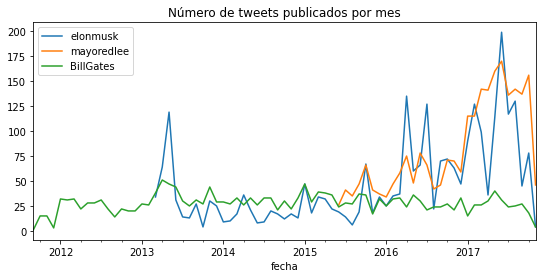

In [4]:
# Distribución temporal de los tweets
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
    df_temp = tweets[tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Número de tweets publicados por mes')
ax.legend();

In [5]:

def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)


In [6]:
# Se aplica la función de limpieza y tokenización a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,"""If one day, my words are against science, cho...","[if, one, day, my, words, are, against, scienc..."
1,I placed the flowers\n\nThree broken ribs\nA p...,"[placed, the, flowers, three, broken, ribs, pi..."
2,Atatürk Anıtkabir https://t.co/al3wt0njr6,"[atatürk, anıtkabir]"
3,"@Bob_Richards One rocket, slightly toasted","[bob, richards, one, rocket, slightly, toasted]"
4,@uncover007 500 ft so far. Should be 2 miles l...,"[uncover, ft, so, far, should, be, miles, long..."


In [7]:
tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


In [8]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
BillGates     31500
elonmusk      33609
mayoredlee    41878
Name: token, dtype: int64

In [9]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
BillGates     4848
elonmusk      6628
mayoredlee    5770
Name: token, dtype: int64

In [10]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
BillGates,15.144231,3.347354
elonmusk,12.611257,6.933870
mayoredlee,17.170152,3.486314


In [11]:
# Top 5 palabras más utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                    
BillGates  4195    BillGates   the   1178
           4271    BillGates    to   1115
           2930    BillGates    of    669
           2084    BillGates    in    590
           2207    BillGates    is    452
elonmusk   10699    elonmusk   the    983
           10816    elonmusk    to    913
           8859     elonmusk    of    638
           7801     elonmusk    is    542
           7656     elonmusk    in    476
mayoredlee 16650  mayoredlee    to   1684
           16568  mayoredlee   the   1338
           11669  mayoredlee   amp   1212
           14957  mayoredlee   our   1096
           15964  mayoredlee    sf    909

In [12]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [13]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,BillGates,elonmusk,mayoredlee
BillGates,1.000000,0.924141,0.820876
elonmusk,0.924141,1.000000,0.781793
mayoredlee,0.820876,0.781793,1.000000


In [14]:
# Número de palabras comunes
# ==============================================================================
palabras_elon = set(tweets_tidy[tweets_tidy.autor == 'elonmusk']['token'])
palabras_bill = set(tweets_tidy[tweets_tidy.autor == 'BillGates']['token'])
palabras_edlee = set(tweets_tidy[tweets_tidy.autor == 'mayoredlee']['token'])

print(f"Palabras comunes entre Elon Musk y Ed Lee: {len(palabras_elon.intersection(palabras_edlee))}")
print(f"Palabras comunes entre Elon Elon Musk y Bill Gates: {len(palabras_elon.intersection(palabras_bill))}")

Palabras comunes entre Elon Musk y Ed Lee: 1882
Palabras comunes entre Elon Elon Musk y Bill Gates: 1882


In [15]:
# Cálculo del log of odds ratio de cada palabra (elonmusk vs mayoredlee)
# ==============================================================================
# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()

# Selección de los autores elonmusk y mayoredlee
tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['elonmusk', 'mayoredlee'])]

# Se añade el total de palabras de cada autor
tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )

# Cálculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.elonmusk/tweets_logOdds.mayoredlee)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es así porque el ratio sea ha
# calculado como elonmusk/mayoredlee.
tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              "elonmusk",
                                              "mayoredlee"
                                    )

In [16]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,elonmusk,mayoredlee,log_odds,abs_log_odds,autor_frecuente
token,,,,,
tesla,0.008123,0.000024,5.829433,5.829433,elonmusk
residents,0.000030,0.006328,-5.359769,5.359769,mayoredlee
yes,0.003570,0.000024,5.007453,5.007453,elonmusk
rocket,0.003273,0.000024,4.920441,4.920441,elonmusk
spacex,0.003065,0.000024,4.854690,4.854690,elonmusk
community,0.000030,0.003797,-4.848943,4.848943,mayoredlee
sf,0.000179,0.021729,-4.801724,4.801724,mayoredlee
falcon,0.002440,0.000024,4.626680,4.626680,elonmusk
landing,0.001964,0.000024,4.409616,4.409616,elonmusk


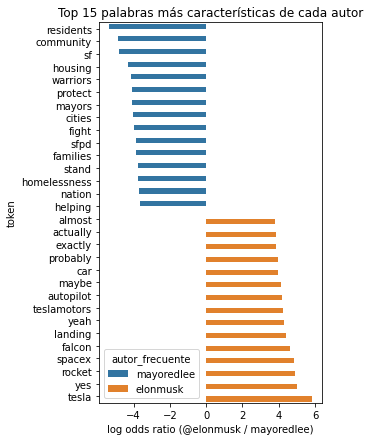

In [17]:
# Top 15 palabras más características de cada autor
# ==============================================================================

top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada autor')
ax.set_xlabel('log odds ratio (@elonmusk / mayoredlee)');

In [18]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = tweets_tidy.copy()
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(3)

,id,token,count,total_count,tf
82366,8.728931e+17,at,1,29,0.034483
82384,8.728931e+17,to,1,29,0.034483
82381,8.728931e+17,some,1,29,0.034483


In [19]:
# Inverse document frequency
# ==============================================================================
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
86751,to,3712,0.660286
81551,the,3499,0.719379
56512,of,2118,1.221384


In [20]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,1.195196e+17,efforts,1,17,0.058824,31,5.445624,0.320331
6591,1.195196e+17,toward,1,17,0.058824,11,6.481716,0.381277
938,1.195196e+17,the,1,17,0.058824,3499,0.719379,0.042316
801,1.195196e+17,support,1,17,0.058824,140,3.937969,0.231645
713,1.195196e+17,proud,1,17,0.058824,88,4.402275,0.258957


In [21]:
# Reparto train y test
# ==============================================================================
datos_X = tweets.loc[tweets.autor.isin(['elonmusk', 'mayoredlee']), 'texto']
datos_y = tweets.loc[tweets.autor.isin(['elonmusk', 'mayoredlee']), 'autor']

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

In [22]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [23]:
# Creación de la matriz tf-idf
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = None,
                    )
tfidf_vectorizador.fit(X_train)

TfidfVectorizer(min_df=3,
                tokenizer=<function limpiar_tokenizar at 0x0000023E03ACC0D0>)

In [24]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

In [25]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 2863
['aa', 'aapi', 'aaronpaul', 'able', 'abort', 'about', 'above', 'abt', 'ac', 'aca']


In [26]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "linear", C = 1.0)
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

SVC(kernel='linear')

In [27]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.154435,0.969024,0.003326,0.997317,0.000448
7,16.681005,0.967073,0.002182,0.999024,0.000228
8,129.154967,0.967073,0.002182,0.999024,0.000228
9,1000.0,0.967073,0.002182,0.999024,0.000228
5,0.278256,0.963902,0.003825,0.981829,0.000956
4,0.035938,0.872439,0.008184,0.886341,0.000892
0,0.00001,0.526829,0.000000,0.526829,0.000000
1,0.000077,0.526829,0.000000,0.526829,0.000000
2,0.000599,0.526829,0.000000,0.526829,0.000000
3,0.004642,0.526829,0.000000,0.526829,0.000000


In [28]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 2.154434690031882} : 0.9690243902439024 accuracy


In [29]:
# Error predicciones test
# ==============================================================================
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predicciones_test),
             columns= ["Elon Musk", "Mayor Ed Lee"],
             index = ["Elon Musk", "Mayor Ed Lee"])

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 1025 clasificaciones: 24
% de error: 2.341463414634146

-------------------
Matriz de confusión
-------------------


,Elon Musk,Mayor Ed Lee
Elon Musk,509,9
Mayor Ed Lee,15,492


In [30]:
# Descarga lexicon sentimientos
# ==============================================================================
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [31]:
# Sentimiento promedio de cada tweet
# ==============================================================================
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "termino",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos = tweets_sentimientos[["autor","fecha", "id", "sentimiento"]] \
                      .groupby(["autor", "fecha", "id"])\
                      .sum().reset_index()
tweets_sentimientos.head()

,autor,fecha,id,sentimiento
0,BillGates,2011-09-29 21:11:15+00:00,1.195196e+17,6
1,BillGates,2011-10-04 19:06:05+00:00,1.213001e+17,-3
2,BillGates,2011-10-06 00:37:29+00:00,1.217459e+17,3
3,BillGates,2011-10-06 00:38:09+00:00,1.217460e+17,6
4,BillGates,2011-10-19 22:12:21+00:00,1.267828e+17,3


In [32]:
def perfil_sentimientos(df):
    print(autor)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")
    print(" ")

for autor, df in tweets_sentimientos.groupby("autor"):
    perfil_sentimientos(df)

BillGates
Positivos: 79.59
Neutros  : 4.64
Negativos: 15.77
 
elonmusk
Positivos: 70.24
Neutros  : 5.02
Negativos: 24.74
 
mayoredlee
Positivos: 80.37
Neutros  : 4.1
Negativos: 15.53
 


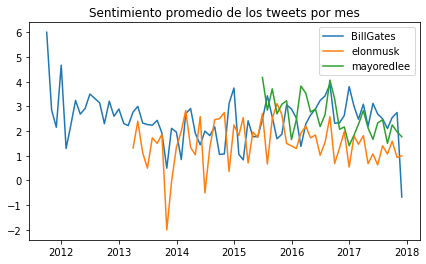

In [33]:
fig, ax = plt.subplots(figsize=(7, 4)) 

for autor in tweets_sentimientos.autor.unique():
    df = tweets_sentimientos[tweets_sentimientos.autor == autor].copy()
    df = df.set_index("fecha")
    df = df[['sentimiento']].resample('1M').mean()
    ax.plot(df.index, df.sentimiento, label=autor)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend();

